In [272]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from fiona.crs import from_epsg

In [273]:
import urllib, json, requests 
import geojson

In [274]:
from ipyleaflet import Map, GeoData, GeoJSON, basemaps, basemap_to_tiles, Icon, Circle, Marker, LayerGroup, WidgetControl
import ipywidgets as widgets
from ipywidgets import Button 
from IPython.display import display, clear_output

In [4]:
#drawing basic map
center = (40.7210907,-73.9877836)
basemap = basemap_to_tiles(basemaps.CartoDB.Positron)

m = Map(layers=(basemap, ), center=center, zoom=15, min_zoom = 7, max_zoom = 20)

button = Button(description="Generate Text")
output = widgets.Output()

widget_control = WidgetControl(widget=button, position='topright')
m.add_control(widget_control)

In [5]:
def extract_location():       
    global gdf, lat, lon
    
    lat = str(markerlocation[0])
    lon = str(markerlocation[1])
    
    df2 = pd.DataFrame(markerlocation)
    df=df2.transpose()
    df.columns=['Latitude','Longitude']

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    
    return gdf

In [6]:
draggable=False
marker_opacity=1
icon = Icon(icon_url='icon.png', icon_size=[15, 15])

marker = Marker(location=center, draggable=draggable, icon=icon, opacity=marker_opacity)

markerlocation = marker.location 

layer_group = LayerGroup(layers=(marker, ))
m.add_layer(layer_group)
   
def update_marker(**kwargs):
    
    if kwargs.get('type') == 'click':
        layer_group.clear_layers();
        
        marker = Marker(location=kwargs.get('coordinates'), draggable=draggable, icon=icon, opacity=marker_opacity, options=['rise_on_hover'])  
        
        global markerlocation
        markerlocation = marker.location 
        
        layer_group.add_layer(marker)
    
        draw_update_buffer(**kwargs)
    
m.on_interaction(update_marker)

In [176]:
def draw_update_buffer(**kwargs):     
    m.on_interaction(update_marker)
    extract_location()
    
    global half_mi
    half_mi=gdf.copy()
    half_mi['geometry'] = half_mi.geometry.buffer(.004,  cap_style=1, join_style=1)

    map_extent = gdf.copy()
    map_extent['geometry'] = map_extent.buffer(1,  cap_style=1, join_style=1)

    diff_half_mi = gpd.overlay(map_extent, half_mi, how='difference')
    
    half_mi_buffer = GeoData(geo_dataframe = diff_half_mi,
                       style={'color': "black", \
                              'fillColor': "#000000", \
                              'fillOpacity': .2, \
                              'opacity': 1, \
                              'weight': 2},
                       name = "Test")

    layer_group.add_layer(half_mi_buffer) 

In [177]:
draw_update_buffer()

m

Map(center=[40.7210907, -73.9877836], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [265]:
gdf

,Latitude,Longitude,geometry
0,40.72294,-73.997499,POINT (-73.99750 40.72294)


Received 11 entries, 11 total


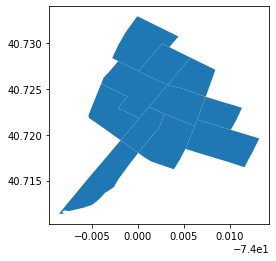

In [335]:
def import_censustracts():
    bounding_box = half_mi.envelope
    df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
    minx, miny, maxx, maxy = df.geometry.total_bounds
    bounds = minx, miny, maxx, maxy

    # census tracts link
    endpoint = 'https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/4/query'
    s = requests.session()
    s.params = {
        'geometry': str(bounds),
        'geometryType': 'esriGeometryEnvelope',
        'inSR': 4326,
        'spatialRel': 'esriSpatialRelIntersects',
        'outFields': 'GEOID,STATE,NAME,STGEOMETRY,OBJECTID',
        'returnGeometry': True,
        'f': 'geojson',        
    }
    start = 0
    done = False
    features = []
    crs = None
    while not done:
        r = s.get(endpoint, params={
            'resultOffset': start,
            'resultRecordCount': 32,
        })
        censusgeo = geojson.loads(r.text)
        newfeats = censusgeo.__geo_interface__['features']
        if newfeats:
            features.extend(newfeats)
            crs=censusgeo.__geo_interface__['crs']
            start += len(newfeats)
            print("Received", len(newfeats), "entries,", start, "total")
        else:
            done = True

    tracts = gpd.GeoDataFrame.from_features(features, crs=crs)
    return tracts

In [10]:
def download_acs():  
    api_key = '9330dc4bf086a84f19fb412bb15f232507301de6'
    acs_url = f'https://api.census.gov/data/2018/acs/acs5/'
#BUT NO NEED FOR SEPARATE TABLES ANYMORE, NO?
    pop_sex = 'B01003_001E,B01001_002E,B01001_026E'
    household_type = 'B11001_002E,B11001_007E'
    education = 'B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E'
    household_income = 'B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B19001_014E,B19001_015E,B19001_016E,B19001_017E'
    means_of_transport = 'B08301_002E,B08301_003E,B08301_003E,B08301_010E,B08301_016E,B08301_017E,B08301_018E,B08301_019E,B08301_020E,B08301_021E'
    travel_time = 'B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,B08303_008E,B08303_009E,B08303_010E,B08303_011E,B08303_012E,B08303_013E'

    # api call using variables instead of directly is way easier
    pop_sex_url = f'{acs_url}?&get={pop_sex}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    household_type_url = f'{acs_url}?&get={household_type}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    education_url = f'{acs_url}?&get={education}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    household_income_url = f'{acs_url}?&get={household_income}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    means_of_transport_url = f'{acs_url}?&get={means_of_transport}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    travel_time_url = f'{acs_url}?&get={travel_time}&for=tract:*&in=state:{state}%20county:*&key={api_key}'

    #load the response into a JSON
    data_acs1=requests.get(pop_sex_url).json()
    data_acs2=requests.get(household_type_url).json()
    data_acs3=requests.get(education_url).json()
    data_acs4=requests.get(household_income_url).json()
    data_acs5=requests.get(means_of_transport_url).json()
    data_acs6=requests.get(travel_time_url).json()
    # print(response_acs.text)

    #ignoring the first element which is column names, replacing columns with the columns from the table
    acs1=pd.DataFrame(data_acs1[1:], columns=data_acs1[0])
    acs2=pd.DataFrame(data_acs2[1:], columns=data_acs2[0])
    acs3=pd.DataFrame(data_acs3[1:], columns=data_acs3[0])
    acs4=pd.DataFrame(data_acs4[1:], columns=data_acs4[0])
    acs5=pd.DataFrame(data_acs5[1:], columns=data_acs5[0])
    acs6=pd.DataFrame(data_acs6[1:], columns=data_acs6[0])
    
    return acs1, acs2, acs3, acs4, acs5, acs6

In [12]:
def join_acs():
    #Combine all acs tables
    acs_only = [acs1, acs2, acs3, acs4, acs5, acs6]
    acs_only = [df.set_index('tract') for df in acs_only]
    acs_only = acs_only[0].join(acs_only[1:])

    #drop duplicate columns
    acs_only = acs_only.loc[:,~acs_only.columns.duplicated()]

    acs_only.rename(columns = { 'state_x': 'state',\
                                'county_x': 'county',\
                            }, inplace=True)
    # #GEOID = state+county+tract
    acs_only["GEOID"]= acs_only['state'].astype(str)+acs_only['county'].astype(str)+acs_only['tract'].astype(str)

    
    tracts_df["area"]=tracts_df[area]
    tracts_clipped = gpd.clip(tracts_df, test)
    tracts_clipped["area"]=tracts_clipped[area]

    #only join after calculating tracts area and clipping to boundary 
    acs_tracts = pd.merge(tracts_df, acs_only, on='GEOID', how='left')

    return acs_only, acs_tracts
# #rename headings, concatenate datasets, summarize etc
# #CENSUS TRACTS

# # acs1.rename(columns = {'B01003_001E':'pop',\
# #                        'B01001_002E':'male',\
# #                        'B01001_026E':'female'\
# #                       }, inplace = True) 

# # acs2.rename(columns = {'B11001_002E':'family',\
# #                        'B11001_007E':'nonfamily'\
# #                       }, inplace = True) 

# # # acs3["lessthan9thgrade"]=acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']
# # # acs3["9thto12thgrade"]= acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']+acs3['']
# # acs3["highschoolgraduate_GED"]= acs3['B15003_017E']+acs3['B15003_018E']
# # acs3["some_college"]= acs3['B15003_019E']+acs3['B15003_020E']
# # acs3["associate_degree"] = acs3['B15003_021E']
# # acs3["bachelors_degree"] = acs3['B15003_022E']
# # acs3["graduate_or_professional_degree"] = acs3['B15003_023E']+acs3['B15003_024E']
# # acs3['doctoratedegree'] = acs3["B15003_025E"]
# # acs3.drop(['B15003_001E','B15003_017E','B15003_018E','B15003_019E','B15003_020E','B15003_021E','B15003_022E','B15003_023E','B15003_024E','B15003_025E'], axis = 1) 

# # acs4["lessthan10000"]= acs4['B19001_002E']
# # acs4["10000to34999"]= acs4['B19001_003E']+acs4['B19001_004E']+acs4['B19001_005E']+acs4['B19001_006E']+acs4['B19001_007E']
# # acs4["35000to49999"] = acs4['B19001_008E']+acs4['B19001_009E']+acs4['B19001_010E']
# # acs4["50000to74999"] = acs4['B19001_011E']+acs4['B19001_011E']
# # acs4["75000to99000"] = acs4['B19001_013E']
# # acs4['100000to199000'] = acs4["B19001_014E"]+acs4['B19001_015E']+acs4['B19001_016E']
# # acs4['200000ormore'] = acs4["B19001_017E"]
# # acs4.drop(['B19001_002E','B19001_003E','B19001_004E','B19001_005E','B19001_006E','B19001_007E','B19001_008E','B19001_009E','B19001_010E','B19001_011E','B19001_012E','B19001_013E','B19001_014E','B19001_015E','B19001_016E','B19001_017E'])

# # acs5.rename(columns = {'B08301_003E':'car_truck_van_drove_alone',\
# #                        'B08301_004E':'car_truck_van_carpool',\
# #                        'B08301_010E':'public_transportation',\
# #                        'B08301_016E':'taxicab',\
# #                        'B08301_017E':'motorcycle',\
# #                        'B08301_018E':'bicycle',\
# #                        'B08301_019E':'walked',\
# #                        'B08301_021E':'worked_at_home',\
# #                        'B08301_020E':'other_means'\
# #                       }, inplace = True) 

# # acs6["lessthan10mins"]= acs6['B08303_002E']+acs6['B08303_003E']
# # acs6["10to29mins"]= acs6['B08303_004E']+acs6['B08303_005E']+acs6['B08303_006E']+acs6['B08303_007E']
# # acs6["30to59mins"]= acs6['B08303_008E']+acs6['B08303_009E']+acs6['B08303_010E']+acs6['B08303_011E']
# # acs6["60minsormore"]= acs6['B08303_012E']+acs6['B08303_013E']
# # acs6.drop(['B08303_002E','B08303_003E','B08303_004E','B08303_005E','B08303_006E','B08303_007E','B08303_008E','B08303_009E','B08303_010E','B08303_011E','B08303_012E','B08303_013E'])

In [ ]:
print(acs_all.columns)
print(tracts_df.columns)

In [ ]:
acs_all.head()

In [ ]:
def clean_acs():

In [ ]:
def proportional_split():

In [ ]:
def aggregate():

In [ ]:
def summary_stats():

In [ ]:
#CHARTS!!! comes after cleaning the data and before buttons

In [ ]:
def generate_text():

In [ ]:
display(button, output)

def on_button_clicked(b):
    output.clear_output()
    
    global state, county
    state, county = find_location()
    
    global acs1, acs2, acs3, acs4, acs5, acs6
    acs1, acs2, acs3, acs4, acs5, acs6 = download_acs()
    
    global acs
    acs=join_acs()
    
    global tracts_df
    tracts_df = import_censustracts()
    
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)

In [ ]:
# button.on_click(on_button_clicked)
m.on_interaction(handle_click)
# marker.observe(on_location_changed, 'location')
    
m

In [ ]:
acs.head()

In [ ]:
#Combine all acs tables
acs_only = [acs1, acs2, acs3, acs4, acs5, acs6]
acs_only = [df.set_index('tract') for df in acs_only]
acs_only = acs_only[0].join(acs_only[1:])

#drop duplicate columns
acs_only = acs_only.loc[:,~acs_only.columns.duplicated()]

acs_only.rename(columns = { 'state_x': 'state',\
                            'county_x': 'county',\
                        }, inplace=True)
# #GEOID = state+county+tract
acs_only["GEOID"]= acs_only['state'].astype(str)+acs_only['county'].astype(str)+acs_only['tract'].astype(str)

acs_only.head()

#     return acs_only

In [ ]:
tracts_df.plot()

In [ ]:
from shapely.geometry import Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import requests

def get_geography(geoid):
    # https://api.censusreporter.org/1.0/geo/tiger2016/16000US5367000?geom=true

    api_url = 'https://api.censusreporter.org/1.0/geo/tiger2016/{0}?geom=true'
    data = requests.get(api_url.format(geoid)).json()


    # Get Features
    fdf = pd.DataFrame({
                        'Geoid': geoid,
                        'LandArea': data['properties']['aland'] / 2589988,
                        'Population': data['properties']['population']
                        }, index=[0])
    fdf['PopulationDensity'] = fdf.Population / fdf.LandArea

    # Convert Points into Geopandas Geometry
    numpy_points =   np.array(data['geometry']['coordinates'][0])
    fdf['Geometry'] = Polygon(numpy_points)

    return gpd.GeoDataFrame(fdf, crs='epsg:4326', geometry = 'Geometry')

get_geography('86000US78666').plot()

In [ ]:
# #drawing basic map
# center = (40.7210907,-73.9877836)
# basemap = basemap_to_tiles(basemaps.CartoDB.Positron)

# icon = Icon(icon_url='icon.png', icon_size=[15, 15])
# marker = Marker(location=center, draggable=False, icon=icon, opacity = 0.8)

# m = Map(layers=(basemap, ), center=center, zoom=15, min_zoom = 11, max_zoom = 20, ax=ax, fig=fig)

# ###HALF-MI BUFFER
# #set location of center as location of the point
# markerlocation=marker.location
# print(markerlocation)
    
# radius = 402 #in-meters
# color = "black"
# fill_color = "white"
# fill_opacity = .2
# weight = 2

# ##click on map to add marker, removes old marker as well
# def handle_click(**kwargs):
#     if kwargs.get('type') == 'click':
#         layer_group.clear_layers();
#         marker = Marker(location=kwargs.get('coordinates'), draggable=False, icon=icon, opacity = 0.8)
#         layer_group.add_layer(marker)
        
#         #updating the circle's location
#         markerlocation=marker.location
#         circle.location = markerlocation
#         layer_group.add_layer(circle);
        
# m.on_interaction(handle_click)
# ######

# #create half-mi buffer
# circle = Circle()
# circle.location = markerlocation
# circle.radius = radius
# circle.color = color
# circle.fill_color = fill_color
# circle.fill_opacity = fill_opacity
# circle.weight = weight
# ###########

    
# # def on_location_changed(event):
# # #remove any circles existing first
# #     layer_group.clear_layers();

# # #update location of center as location of the point
# #     markerlocation = marker.location
# #     circle.location = markerlocation
# #     layer_group.add_layer(circle);
        
# # pass
# # marker.observe(on_location_changed, 'location')
# # #######


# # #adding button that performs the analysis on click 
# # button = Button(description="Reset")

# # def on_button_clicked(b, geo_json):   
    
# # button.on_click(on_button_clicked)

    
# # widget_control = WidgetControl(widget=button, position='topright')
# # m.add_control(widget_control)

# m.add_control(LayersControl())

# layer_group = LayerGroup(layers=(marker, circle))
# m.add_layer(layer_group)

# # display(m)